<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

In [1]:
import numpy as np
import pandas as pd
%pylab inline
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls ../../data/samsung_activities/

samsung_test_labels.txt  samsung_train_labels.txt
samsung_test.txt	 samsung_train.txt


**Данные Samsung Human Activity Recognition. [Скачать](https://yadi.sk/d/ha-lprkDvozGx)**

In [3]:
X_train = np.loadtxt(
    '../../data/samsung_activities/samsung_train.txt')
y_train = np.loadtxt(
    '../../data/samsung_activities/samsung_train_labels.txt').astype(int)
X_test = np.loadtxt(
    '../../data/samsung_activities/samsung_test.txt')
y_test = np.loadtxt(
    '../../data/samsung_activities/samsung_test_labels.txt').astype(int)

In [4]:
X_train.shape, X_test.shape

((7352, 561), (2947, 561))

**Выделим столько главных компонент, чтоб осталось 90% дисперсии исходных данных.**

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)

X_test_pca = pca.transform(scaler.transform(X_test))
print(X_test_pca.shape)

(7352, 63)
(2947, 63)


**Зафиксируем объект StratifiedKFold, с его помощью будет проводить кросс-валидацию.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

**Используйте sklearn-обертку Xgboost для оценки доли правильных ответов на кросс-валидации с данными (X_train_pca, y_train). Укажите параметры XGBClassifier n_estimators = 10 (по умолчанию – 100) и seed=7 (это то же по сути, что random_state). Выведите среднюю долю правильных ответов на кросс-валидации, используйте ранее созданный объект StratifiedKFold.**

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [8]:
xgb_model1 = XGBClassifier(n_estimators=10, seed=7)

In [9]:
%%time
print('Средняя доля правильных ответов на кросс-валидации: {}'\
      .format(cross_val_score(xgb_model1, X_train_pca, y_train, scoring='accuracy', cv=skf).mean()))

Средняя доля правильных ответов на кросс-валидации: 0.8106667626267473
CPU times: user 6.05 s, sys: 236 ms, total: 6.29 s
Wall time: 798 ms


**Постройте кривые валидации по глубине деревьев. Все прочие параметры кросс-валидации возьмите как на предыдущем шаге. Достаточно сохранять только среднюю долю правильных ответов на валидационной части (на обучающей – не обязательно).**

In [10]:
%%time
tree_depths = [6, 9, 12, 15]
xgb_train_scores = []
xgb_test_scores = []

for depth in tree_depths:
    print(depth, end=',')
    xgb_model = XGBClassifier(max_depth=depth, n_estimators=10, seed=7)
    xgb_train_scores.append(
        cross_val_score(xgb_model, X_train_pca, y_train, scoring='accuracy', cv=skf).mean())
    xgb_test_scores.append(
        cross_val_score(xgb_model, X_test_pca, y_test, scoring='accuracy', cv=skf).mean())
print()

6,9,12,15,
CPU times: user 2min 13s, sys: 188 ms, total: 2min 13s
Wall time: 18.5 s


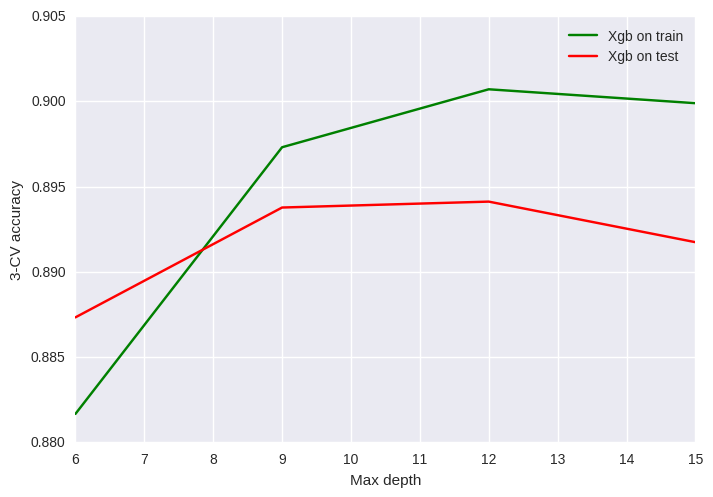

In [11]:
plot(tree_depths, xgb_train_scores, color='green', label='Xgb on train');
plot(tree_depths, xgb_test_scores, color='red', label='Xgb on test');
xlabel('Max depth')
ylabel('3-CV accuracy')
legend();

**Используйте RandomizedGridSearch, чтобы настроить параметры бустинга. Задайте 10 итераций (будут перебираться случайные 10 комбинаций параметров), а кросс-валидацию – как ранее. Выведите лучшие параметры и accuracy (поля best\_params\_ и best\_score\_ у обученного RandomizedGridSearch). Сделайте то же самое для случайного леса.**

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [13]:
xgb_params_dist_grid = {
    'max_depth': np.arange(10,14),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': [0.5, 0.75, 1.],
    'colsample_bytree': [0.5, 0.75, 1.]
}
xgb_params_fixed = {
    'n_estimators': 10,
    'silent': 1,
    'seed': 7
}

In [14]:
xgb_grid = RandomizedSearchCV(
    XGBClassifier(**xgb_params_fixed),
    xgb_params_dist_grid,
    n_iter=10,
    cv=skf
)

In [15]:
%%time
xgb_grid.fit(X_train_pca, y_train);

CPU times: user 2min 8s, sys: 136 ms, total: 2min 8s
Wall time: 16.7 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=1, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'subsample': [0.5, 0.75, 1.0], 'colsample_bytree': [0.5, 0.75, 1.0], 'max_depth': array([10, 11, 12, 13]), 'gamma': array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [16]:
xgb_grid.best_params_

{'colsample_bytree': 0.5, 'gamma': 0.25, 'max_depth': 11, 'subsample': 1.0}

In [17]:
xgb_grid.best_score_

0.91403699673558214

**Теперь для сравнения случайный лес.**

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf_params_dist_grid = {
    'max_depth': np.arange(10,14),
    'max_features': np.linspace(0.2, 0.5, 10)
}
rf_params_fixed = {
    'n_estimators': 10,
    'random_state': 7
}

In [20]:
rf_grid = RandomizedSearchCV(
    RandomForestClassifier(**rf_params_fixed),
    rf_params_dist_grid,
    n_iter=10,
    cv=skf
)

In [21]:
%%time
rf_grid.fit(X_train_pca, y_train)

CPU times: user 18.4 s, sys: 12 ms, total: 18.4 s
Wall time: 18.4 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=7,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': array([10, 11, 12, 13]), 'max_features': array([ 0.2    ,  0.23333,  0.26667,  0.3    ,  0.33333,  0.36667,
        0.4    ,  0.43333,  0.46667,  0.5    ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [22]:
rf_grid.best_params_, rf_grid.best_score_

({'max_depth': 13, 'max_features': 0.3666666666666667}, 0.89907508161044614)

**Проверьте доли правильных ответов настроенного и изначального бустинга, а также случайного леса на оставленной выборке.**

In [23]:
# first xgb
xgb_model1.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=1)

In [24]:
accuracy_score(y_test, xgb_model1.predict(X_test_pca))

0.78588394977943676

In [25]:
# tuned xgb
accuracy_score(y_test, xgb_grid.best_estimator_.predict(X_test_pca))

0.85578554462164913

In [26]:
# tuned forest
accuracy_score(y_test, rf_grid.best_estimator_.predict(X_test_pca))

0.82558534102477099

**Наконец, подберите число итераций бустинга. Постройте кривые валидации Xgboost с помощью функции cv из xgboost.**

In [27]:
from xgboost import cv, DMatrix

In [28]:
# каприз Xgboost: надо чтоб метки были от 0 до n_classes-1
y_train -= 1
y_test -= 1

In [29]:
dtrain = DMatrix(X_train_pca, y_train)

In [30]:
best_xgb_params = {'colsample_bytree': 0.75, 'gamma': 0.25, 
                   'max_depth': 11, 'subsample': 1.0,
                    'silent': 1, 
                   'eval_metric': 'merror',
                   'num_class': 6,
                    'seed': 7}

In [31]:
# 20 iterations
cv_result = cv(best_xgb_params, dtrain, num_boost_round=20)

In [32]:
cv_result.head()

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.172245,0.003999,0.034149,0.003309
1,0.134422,0.003024,0.011020,0.000667
2,0.117007,0.003500,0.004626,0.000787
3,0.106667,0.000385,0.002177,0.000347
4,0.098367,0.001731,0.001361,0.000420


In [33]:
def plot_with_err(index, means, stds=None, **kwargs):
    lines = plt.plot(index, means, '-', **kwargs)
    plt.fill_between(index, means - stds, means + stds, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

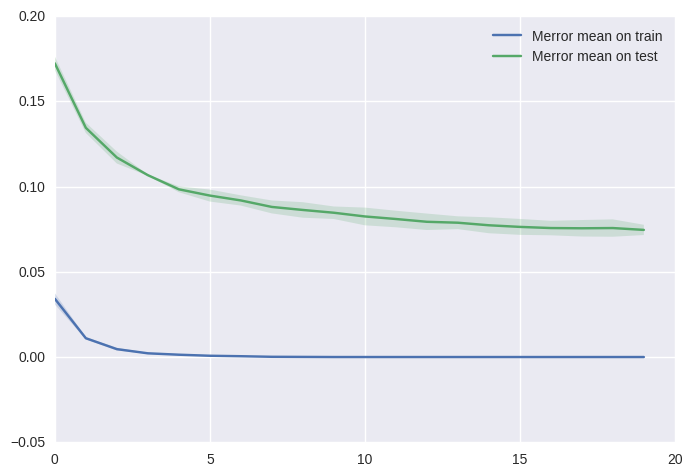

In [34]:
plot_with_err(cv_result.index, cv_result['train-merror-mean'], 
              cv_result['train-merror-std'], label='Merror mean on train');
plot_with_err(cv_result.index, cv_result['test-merror-mean'], 
              cv_result['test-merror-std'], label='Merror mean on test');
legend();

In [35]:
%%time
# 100 iterations
cv_result2 = cv(best_xgb_params, dtrain, num_boost_round=100)

CPU times: user 1min 35s, sys: 148 ms, total: 1min 35s
Wall time: 12.2 s


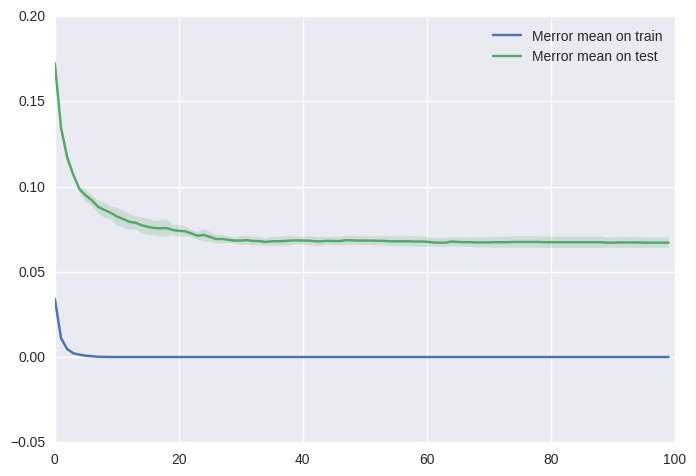

In [36]:
plot_with_err(cv_result2.index, cv_result2['train-merror-mean'], 
              cv_result2['train-merror-std'], label='Merror mean on train');
plot_with_err(cv_result2.index, cv_result2['test-merror-mean'], 
              cv_result2['test-merror-std'], label='Merror mean on test');
legend();

In [37]:
best_num_rounds = np.argmin(cv_result2['test-merror-mean'])

**Проверьте долю правильных ответов последней версии бустинга на оставленной выборке. Используйте функцию train из xgboost. X_test также надо будет переделать в DMatrix, только ответы y_test туда уже не передавайте.**

In [38]:
from xgboost import train

In [39]:
final_xgb = train(best_xgb_params, dtrain, best_num_rounds)

In [40]:
accuracy_score(y_test, final_xgb.predict(DMatrix(X_test_pca)))

0.88564642008822536